# Project
## Init stuff

In [1]:
import sys
import os
import argparse
import random
import shutil

import datetime
import time
import copy

import numpy as np
import sklearn

import scipy as sp
import pandas as pd

import torch
import torchvision

# we'll use torch for neural networks
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader, random_split

# we'll use torchvision for computer vision tasks
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision.datasets import CIFAR10
import torchvision.utils as vutils
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

%matplotlib inline
from matplotlib import pyplot as plt
seed = 42 # deterministic seed
torch.manual_seed(seed)
np.random.seed(seed) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training and inference with device: {device}')

Training and inference with device: cuda


## Gets labels and data

In [2]:
image_path = "images"

labels = [item for item in os.listdir(image_path) if os.path.isdir(os.path.join(image_path,item))]
labels = sorted(labels)
print(labels)
# Gets image data from files

# OLD CODE - NO DATA AUGMENTATION
# Different image_transform because of pretrained model
# image_transform =  Compose([transforms.PILToTensor()])
# image_transform = Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(), 
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
# image_data= torchvision.datasets.ImageFolder(image_path, transform=image_transform)

# train_data, eval_data = random_split(image_data, [.7, .3])
#data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                           saturation=0.2, hue=0.08),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.15)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

#directories for images, train, val, test
train_path = "train"
val_path = "val"
test_path = "test"

# Create directories for train, val, and test sets
for path in [train_path, val_path, test_path]:
    if not os.path.exists(path):
        os.makedirs(path)

# Get the class labels
full_ds = torchvision.datasets.ImageFolder(image_path)
class_to_idx = full_ds.class_to_idx

# Splitting data into train, val, and test sets
train_idx, val_test_idx = train_test_split(range(len(full_ds)), test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=42)

# Creating directories for train, val, and test images
for split, idxs in zip(['train', 'val', 'test'], [train_idx, val_idx, test_idx]):
    split_path = os.path.join({'train': train_path, 'val': val_path, 'test': test_path}[split])
    for label in class_to_idx:
        label_path = os.path.join(split_path, label)
        if not os.path.exists(label_path):
            os.makedirs(label_path)

#Move images to assigned directories
for i, (img_path, label) in enumerate(full_ds.imgs):
    if i in train_idx:
        split_path = train_path
    elif i in val_idx:
        split_path = val_path
    else:
        split_path = test_path
    label_path = os.path.join(split_path, full_ds.classes[label])
    shutil.copy(img_path, label_path)

# Now you can load the train, val, and test sets
train_ds = torchvision.datasets.ImageFolder(train_path)
val_ds = torchvision.datasets.ImageFolder(val_path)

# Apply transforms to the datasets
train_ds.transform = train_transform
val_ds.transform = val_transform

# Dataloaders for each set
train_data = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_data = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

['backpack', 'book', 'calculator', 'chair', 'clock', 'desk', 'keychain', 'laptop', 'paper', 'pen', 'phone', 'water bottle']


/apps/pytorch/2.2.0/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Display a Batch of Data

['clock', 'book', 'clock', 'clock', 'laptop', 'book', 'chair', 'phone', 'pen', 'paper', 'paper', 'keychain', 'keychain', 'paper', 'keychain', 'calculator', 'book', 'clock', 'phone', 'keychain', 'desk', 'book', 'desk', 'clock', 'chair', 'clock', 'book', 'backpack', 'backpack', 'desk', 'laptop', 'chair']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


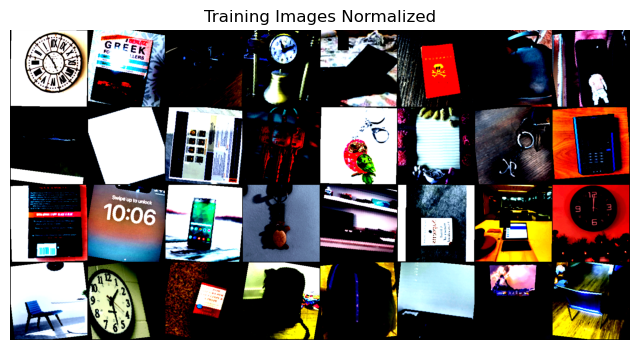

In [3]:
# Displaying the training images normalized that we will use for training 

iterator = iter(train_data)
batch = next(iterator)
image_labels = [ labels[i] for i in batch[-1]]
print(image_labels)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images Normalized")
plt.imshow(np.transpose(vutils.make_grid(batch[0]),(1,2,0)))

['clock', 'book', 'clock', 'clock', 'laptop', 'book', 'chair', 'phone', 'pen', 'paper', 'paper', 'keychain', 'keychain', 'paper', 'keychain', 'calculator', 'book', 'clock', 'phone', 'keychain', 'desk', 'book', 'desk', 'clock', 'chair', 'clock', 'book', 'backpack', 'backpack', 'desk', 'laptop', 'chair']


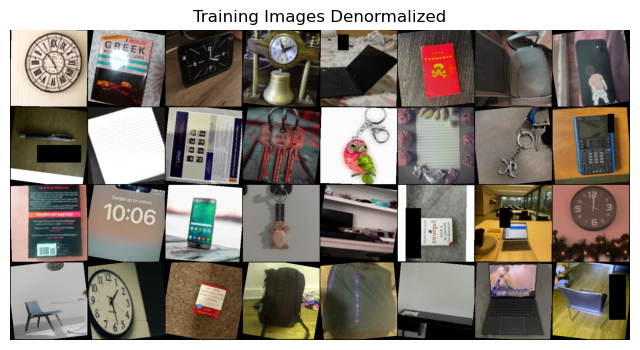

In [4]:
# Displaying the denormalized training images in order to actually visualize the data without over saturation

print(image_labels)
def denormalize_batch(batch_tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    batch_tensor = batch_tensor.clone() * std + mean
    return torch.clamp(batch_tensor, 0, 1)

images_denorm = denormalize_batch(batch[0], [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images Denormalized")
plt.imshow(np.transpose(vutils.make_grid(images_denorm, nrow=8), (1, 2, 0)))
plt.show()


In [5]:
#Distribution of classes

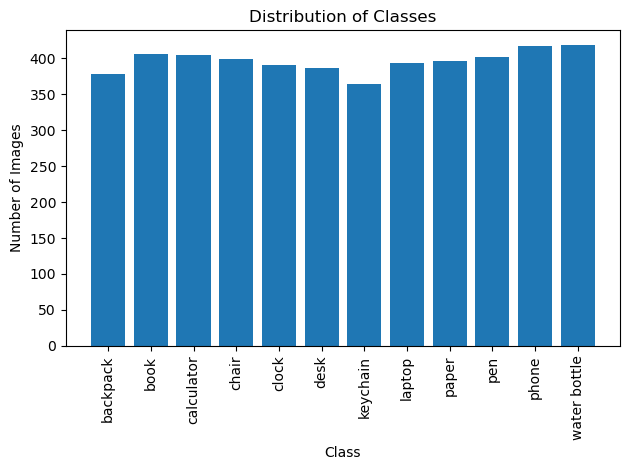

In [6]:
classes = full_ds.classes

#Get number of images in each class
class_counts = [0] * len(classes)
for _, label in full_ds.samples:
    class_counts[label] += 1

# Plot histogram of class distribution
plt.bar(classes, class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes')
plt.xticks(rotation=90)  
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()


## Creating the model

In [7]:
# ResNet18 model version 

def create_resnet18_model(num_classes):
    from torchvision.models import resnet18, ResNet18_Weights

    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights = weights)

    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

    for param in model.parameters():
        param.requires_grad = False

    for param in model.fc.parameters():
        param.requires_grad = True

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    loss_func = nn.CrossEntropyLoss()

    return model, optimizer, loss_func

In [16]:
model, optimizer, loss_func = create_resnet18_model(num_classes = 12)
model = model.to(device)

## Training the model

In [17]:
def train_model(model, train_loader, val_loader, optimizer, loss_func, device, patience, min_delta, lr_step, lr_gamma, epochs = 5):

    scheduler = (torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=lr_gamma)
                 if lr_step else None)
    best_val_acc = 0.0
    patience_counter = 0 # patience for early stopping
    val_accuracies = []
    train_accuracies = []
    # iterate for set number of epochs
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        # training loop, compute gradients, optimize
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = loss_func(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim = 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)
        train_accuracies.append(train_acc)
        # eval loop
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_preds = torch.argmax(val_outputs, dim=1)
                val_correct += (val_preds == val_labels).sum().item()
                val_total += val_labels.size(0)
        val_acc = val_correct / val_total
        val_accuracies.append(val_acc)
        if scheduler:
            scheduler.step()

        # if val is better than current best val, update val, else trigger early stopping
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered. Restoring best weights.")
                model.load_state_dict(torch.load('best.pt'))
                break

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.ylim([0, 1])
    plt.savefig('val_test_accuracy.png')
    plt.show()
   
    return model



Epoch 1/50, Loss: 1.6842, Train Acc: 0.5056, Val Acc: 0.7913
Epoch 2/50, Loss: 0.9908, Train Acc: 0.7420, Val Acc: 0.7815
Epoch 3/50, Loss: 0.8329, Train Acc: 0.7768, Val Acc: 0.8459
Epoch 4/50, Loss: 0.7702, Train Acc: 0.7777, Val Acc: 0.8529
Epoch 5/50, Loss: 0.7201, Train Acc: 0.7840, Val Acc: 0.8445
Epoch 6/50, Loss: 0.6925, Train Acc: 0.7957, Val Acc: 0.8655
Epoch 7/50, Loss: 0.6608, Train Acc: 0.8059, Val Acc: 0.8655
Epoch 8/50, Loss: 0.6280, Train Acc: 0.8117, Val Acc: 0.8529
Epoch 9/50, Loss: 0.6356, Train Acc: 0.8129, Val Acc: 0.8585
Epoch 10/50, Loss: 0.6098, Train Acc: 0.8183, Val Acc: 0.8459
Epoch 11/50, Loss: 0.5939, Train Acc: 0.8183, Val Acc: 0.8627
Epoch 12/50, Loss: 0.5825, Train Acc: 0.8228, Val Acc: 0.8669
Epoch 13/50, Loss: 0.5521, Train Acc: 0.8231, Val Acc: 0.8669
Epoch 14/50, Loss: 0.5615, Train Acc: 0.8306, Val Acc: 0.8683
Epoch 15/50, Loss: 0.5497, Train Acc: 0.8369, Val Acc: 0.8725
Epoch 16/50, Loss: 0.5327, Train Acc: 0.8315, Val Acc: 0.8431
Epoch 17/50, Loss

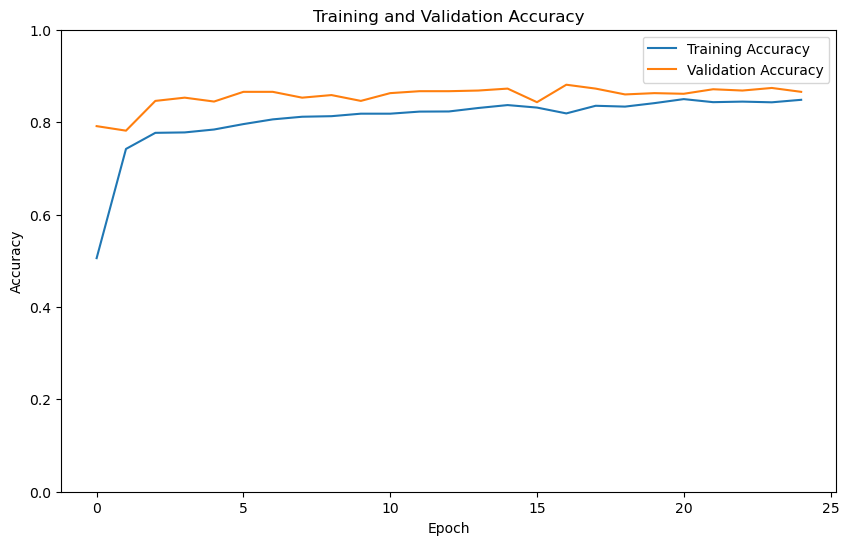

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
train_model(model, train_data, val_data, optimizer, loss_func, device, patience = 8, min_delta = 1e-3, lr_step = 20, lr_gamma = 0.3, epochs = 50)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def create_cnn(num_classes):
    class CNN(nn.Module):
        def __init__(self, num_classes):
            super(CNN, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, 3, padding="same")  # Input: 3 channels, Output: 16 filters
            #self.batch1 = nn.BatchNorm2d(32)
            self.conv2 = nn.Conv2d(32, 64, 3, padding="same")
            #self.batch2 = nn.BatchNorm2d(64)
            self.conv3 = nn.Conv2d(64, 128, 3, padding="same")
            #self.batch3 = nn.BatchNorm2d(128)
            self.conv4 = nn.Conv2d(128, 256, 3, padding="same")
            #self.batch4 = nn.BatchNorm2d(256)
            self.conv5 = nn.Conv2d(256, 512, 3, padding="same")
            #self.batch5 = nn.BatchNorm2d(512)
            #224 -> 112 -> 56 -> 28 -> 14 - >7
            self.pool = nn.MaxPool2d(2, 2)
            
            self.fc1 = nn.Linear(512 * 7 * 7, 128)
            self.fc2 = nn.Linear(128, num_classes)
            self.dropout = nn.Dropout(0.3)
            
        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = self.pool(F.relu(self.conv4(x)))
            x = self.pool(F.relu(self.conv5(x)))
            
            x = x.view(x.size(0), -1) # flatten
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            
            return x

    model = CNN(num_classes=num_classes)
                          
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
    model.optimizer = optimizer
    model.loss_func = nn.CrossEntropyLoss(label_smoothing=0.1)

    return model


In [20]:
model = create_cnn(num_classes = 12)
model = model.to(device)

In [21]:

def train_cnn_model(model, train_loader, val_loader, device, patience, min_delta, lr_step, lr_gamma, epochs=5):
    scheduler = ReduceLROnPlateau(model.optimizer, "max", factor=0.5, patience=4)

    best_val_acc = 0.0
    patience_counter = 0  # patience for early stopping
    val_accuracies = []
    train_accuracies = []

    # iterate for set number of epochs
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        # training loop, compute gradients, optimize
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = model.loss_func(outputs, labels)
            model.optimizer.zero_grad()
            loss.backward()
            model.optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)
        train_accuracies.append(train_acc)

        # eval loop
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_preds = torch.argmax(val_outputs, dim=1)
                val_correct += (val_preds == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_acc = val_correct / val_total
        val_accuracies.append(val_acc)

        scheduler.step(val_acc)
        print(scheduler.get_last_lr())

        # if val is better than current best val, update val, else trigger early stopping
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_cnn_model.pt')  # <<< SAVE filename
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered. Restoring best weights.")
                model.load_state_dict(torch.load('best_cnn_model.pt'))  # <<< LOAD same filename
                break

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.ylim([0, 1])
    plt.show()

    return model


[0.001]
Epoch 1/75, Loss: 2.4340, Train Acc: 0.1319, Val Acc: 0.2087
[0.001]
Epoch 2/75, Loss: 2.2974, Train Acc: 0.2115, Val Acc: 0.2815
[0.001]
Epoch 3/75, Loss: 2.2013, Train Acc: 0.2764, Val Acc: 0.3123
[0.001]
Epoch 4/75, Loss: 2.1367, Train Acc: 0.3019, Val Acc: 0.3333
[0.001]
Epoch 5/75, Loss: 2.0962, Train Acc: 0.3316, Val Acc: 0.3978
[0.001]
Epoch 6/75, Loss: 2.0126, Train Acc: 0.3785, Val Acc: 0.4188
[0.001]
Epoch 7/75, Loss: 1.9823, Train Acc: 0.3857, Val Acc: 0.4244
[0.001]
Epoch 8/75, Loss: 1.9382, Train Acc: 0.3956, Val Acc: 0.4244
[0.001]
Epoch 9/75, Loss: 1.8991, Train Acc: 0.4233, Val Acc: 0.4552
[0.001]
Epoch 10/75, Loss: 1.8714, Train Acc: 0.4437, Val Acc: 0.4426
[0.001]
Epoch 11/75, Loss: 1.8528, Train Acc: 0.4629, Val Acc: 0.4846
[0.001]
Epoch 12/75, Loss: 1.8285, Train Acc: 0.4671, Val Acc: 0.4552
[0.001]
Epoch 13/75, Loss: 1.7989, Train Acc: 0.4830, Val Acc: 0.4832
[0.001]
Epoch 14/75, Loss: 1.7643, Train Acc: 0.4974, Val Acc: 0.5084
[0.001]
Epoch 33/75, Loss: 1.

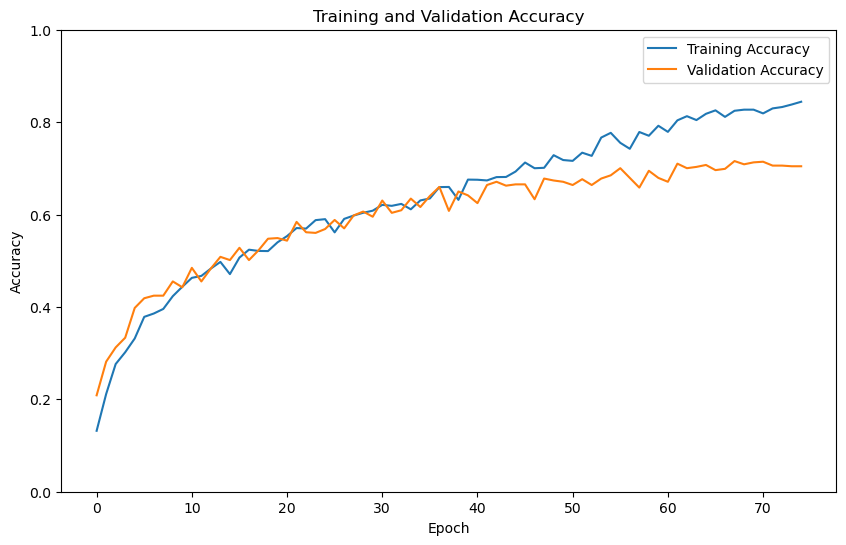

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=12, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (loss_func): CrossEntropyLoss()
)

In [22]:
train_cnn_model(model, train_data, val_data, device, patience = 8, min_delta = 1e-3, lr_step = 10, lr_gamma = 0.9, epochs = 75)